## cDCGAN for Ising model dataset
In this notebook I create a conditional deep convolutional GAN to generate Ising model configurations at specific temperatures.

In [46]:
import tensorflow as tf
tf.enable_eager_execution()

%matplotlib inline
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow import keras
import glob
import imageio
import PIL
import time

from IPython import display

In [2]:
train_data = '../../../data/Ising/train/'

In [3]:
def one_hot_label(img):
    label,T,_,_ = img.split('_')
    if label == 'low':
        ohl = np.array([1,0])
    elif label == 'high':
        ohl = np.array([0,1])
    return ohl,np.round((float(T)-1.5)/0.1)
def temp_label(img):
    label,T,_,_ = img.split('_')
    return float(T)
def train_data_with_label(train_path,*args):
    train_images = []
    if args:
        for category in args:
            for i in tqdm(os.listdir(train_path + category)):
                path = os.path.join(train_path, category,i)
                img = np.load(path)
                #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                #img = cv2.resize(img, (128,128))
                train_images.append([img, one_hot_label(i)])
        shuffle(train_images)
        return train_images

In [4]:
train_set=train_data_with_label(train_data,'low','high')

100%|██████████| 7000/7000 [00:01<00:00, 3811.55it/s]


In [5]:
tr_img_data = np.array([i[0] for i in train_set]).reshape(-1,20,20,1)
tr_img_data_float = tr_img_data.astype(dtype='float32')

In [6]:
tr_lbl_data = np.array([i[1][1] for i in train_set])

In [7]:
len(np.unique(tr_lbl_data))

18

In [8]:
np.unique(tr_lbl_data)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17.])

In [9]:
train_labels_emb = tf.keras.utils.to_categorical(tr_lbl_data, 18)

In [10]:
tr_lbl_data[3]

9.0

In [11]:
train_labels_emb[3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

Load in the data: Shape of ```train_images``` is (Number of imgs, img size axis 0, img size axis 1).
Shape of ```train_labels``` is 1D array of lables.

In [12]:
BUFFER_SIZE = 12500
BATCH_SIZE = 64

Create a tensorflow dataset object that acts as a pipeline for feeding data to the model.

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((tr_img_data_float,train_labels_emb)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [36]:
for batch in train_dataset:
    print(batch[0])

tf.Tensor(
[[[[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]

  ...

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]]


 [[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]]


 [[[-1.]
   [-1.]
   [-1.]
   ...
   [ 1.]
   [-1.]
   [ 1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]

  ...

  [[-1.]
   [ 1.]
 

tf.Tensor(
[[[[ 1.]
   [ 1.]
   [ 1.]
   ...
   [-1.]
   [-1.]
   [ 1.]]

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [-1.]
   [-1.]
   [ 1.]]

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]

  ...

  [[-1.]
   [-1.]
   [-1.]
   ...
   [ 1.]
   [ 1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [ 1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]]


 [[[-1.]
   [-1.]
   [ 1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [-1.]
   [-1.]]

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]

  [[-1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [ 1.]
   [-1.]]

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [-1.]
   [ 1.]]]


 [[[ 1.]
   [ 1.]
   [ 1.]
   ...
   [-1.]
   [-1.]
   [ 1.]]

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [-1.]
   [-1.]]

  [[ 1.]
   [ 1.]
   [ 1.]
   ...
   [ 1.]
   [ 1.]
   [ 1.]]

  ...

  [[ 1.]
   [ 1.]
 

   [-1.]]]], shape=(64, 20, 20, 1), dtype=float32)
tf.Tensor(
[[[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [ 1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [ 1.]]

  [[-1.]
   [ 1.]
   [ 1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [ 1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]]


 [[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]]


 [[[ 1.]
   [ 1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [

## Create the generator network
This network will take in a string of 100 random numbers (noise)

In [37]:
def make_generator_model():
    # Input is x (noise) and y (label)
    input_x = tf.keras.layers.Input(shape=(100,), name='noise_input')
    x = tf.keras.layers.Dense(5*5*128,use_bias=False)(input_x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    reshape_x = tf.keras.layers.Reshape((5, 5, 128))(x)
    
    input_y = tf.keras.layers.Input(shape=(18,), name='label_input')
    y = tf.keras.layers.Dense(5*5*128,use_bias=False)(input_y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.LeakyReLU()(y)
    
    reshape_y = tf.keras.layers.Reshape((5, 5, 128))(y)
    
    xy = tf.keras.layers.concatenate([reshape_x, reshape_y])
    
    xy = tf.keras.layers.Conv2DTranspose(128,(5,5),strides=(1, 1), padding='same', use_bias=False)(xy)
    xy = tf.keras.layers.BatchNormalization()(xy)
    xy = tf.keras.layers.LeakyReLU()(xy)
    
    xy = tf.keras.layers.Conv2DTranspose(64,(5,5),strides=(2, 2), padding='same', use_bias=False)(xy)
    #assert xy.output_shape == (None, 10, 10, 64)
    xy = tf.keras.layers.BatchNormalization()(xy)
    xy = tf.keras.layers.LeakyReLU()(xy)
    
    xy_final = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(xy)
    
    model = tf.keras.Model(inputs=[input_x, input_y], outputs=xy_final)
  
    return model

In [38]:
def make_discriminator_model():
    
    # Input is x (noise) and y (label)
    input_x = tf.keras.layers.Input(shape=(20,20,1), name='image_input')
    x = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    #reshape_x = tf.keras.layers.Reshape((7, 7, 256))(x)
    
    input_y = tf.keras.layers.Input(shape=(18,), name='label_input')
    y = tf.keras.layers.Dense(1024)(input_y)
    y = tf.keras.layers.LeakyReLU()(y)
    
    y = tf.keras.layers.Dense(5*5*128)(y)
    y = tf.keras.layers.LeakyReLU()(y)
    y = tf.keras.layers.BatchNormalization()(y)
    
    reshape_y = tf.keras.layers.Reshape((5, 5, 128))(y)
    
    xy = tf.keras.layers.concatenate([x, reshape_y])
    
    xy = tf.keras.layers.Flatten()(xy)
    xy = tf.keras.layers.Dense(1024)(xy)
    xy = tf.keras.layers.LeakyReLU()(xy)
    
    xy_final = tf.keras.layers.Dense(1)(xy)
    
    model = tf.keras.Model(inputs=[input_x, input_y], outputs=xy_final)

    return model

In [53]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [54]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [55]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [56]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

In [128]:
checkpoint_dir = './training_checkpoints_cGAN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [57]:
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])
tmpList=np.arange(16)

labels_for_generation = tf.keras.utils.to_categorical(tmpList,18)


In [58]:
def train_step(images,labels,gen_loss_log,disc_loss_log):
   # generating noise from a normal distribution
      current_batch_size = tf.shape(labels)[0]
      noise = tf.random_normal([current_batch_size, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise,labels], training=True)
      
        real_output = discriminator([images,labels], training=True)
        generated_output = discriminator([generated_images,labels], training=True)
         
        gen_loss = generator_loss(generated_output)
        gen_loss_log.append(gen_loss)
        disc_loss = discriminator_loss(real_output, generated_output)
        disc_loss_log.append(disc_loss)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [59]:
#train_step = tf.contrib.eager.defun(train_step)

In [60]:
def train(dataset, epochs,gen_loss_log,disc_loss_log):  
  for epoch in range(epochs):
    start = time.time()
    
    for batch in dataset:
      images = batch[0]
      lbls = batch[1]
      train_step(images,lbls,gen_loss_log,disc_loss_log)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation,labels_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
    #generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation,labels_for_generation)


In [61]:
def generate_and_save_images(model, epoch, test_input_noise,test_input_labels):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  #predictions = model([test_input_noise,test_input_labels], training=False)
  predictions = tf.round(model([test_input_noise,test_input_labels], training=False))

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

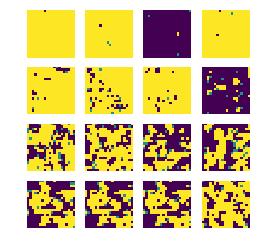

CPU times: user 17min 3s, sys: 35.1 s, total: 17min 38s
Wall time: 16min 26s


In [62]:
%%time
EPOCHS = 50
gen_loss_log=[]
disc_loss_log=[]
train(train_dataset, EPOCHS,gen_loss_log,disc_loss_log)

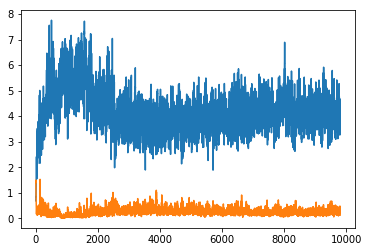

In [63]:
plt.plot(np.asarray(gen_loss_log))
plt.plot(np.asarray(disc_loss_log))

In [25]:
np.save('GeneratorLoss_cGAN.npy',np.asarray(gen_loss_log))
np.save('DiscriminatorLoss_cGAN.npy',np.asarray(disc_loss_log))

In [64]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

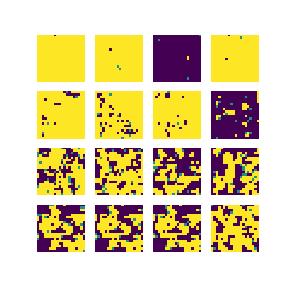

In [70]:
display_image(EPOCHS)

In [66]:
with imageio.get_writer('c_dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
    
# this is a hack to display the gif inside the notebook
os.system('cp c_dcgan.gif c_dcgan.gif.png')

0

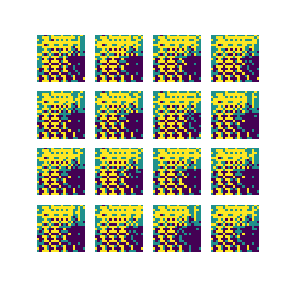

In [67]:
display.Image(filename="c_dcgan.gif.png")